In [6]:
# Import Packges

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Reshape, Conv2D, PReLU, Flatten, Dense, Activation
from tensorflow.keras.losses import MeanSquaredError

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import time

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# DeepONet Class : BranchNet and TrunkNet
class DeepONet_Model(tf.keras.Model):

    def __init__(self, Par):
        super(DeepONet_Model, self).__init__()
        np.random.seed(23)
        tf.random.set_seed(23)

        #Defining some model parameters
        self.latent_dim = 100

        self.Par = Par

        self.index_list = []
        self.train_loss_list = []
        self.val_loss_list = []

        self.lr=10**-4
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

        self.branch_net = Sequential()
        self.branch_net.add(Dense(100, activation='relu'))
        self.branch_net.add(Dense(100, activation='relu'))
        self.branch_net.add(Dense(100, activation='relu'))
        self.branch_net.add(Dense(100, activation='relu'))
        self.branch_net.add(Dense(self.latent_dim))


        self.trunk_net  = Sequential()
        self.trunk_net.add(Dense(100, activation='relu'))
        self.trunk_net.add(Dense(100, activation='relu'))
        self.trunk_net.add(Dense(100, activation='relu'))
        self.trunk_net.add(Dense(100, activation='relu'))
        self.trunk_net.add(Dense(self.latent_dim))

    def call(self, X_func, X_loc):
    #X_func -> [BS, m]
    #X_loc  -> [npoints_output, 1]

        y_func = self.branch_net(X_func)

        y_loc = self.trunk_net(X_loc)

        Y = tf.einsum('ij,kj->ik', y_func, y_loc)

        return(Y)

    def c_loss(self, y_pred, y_train):

        #-------------------------------------------------------------#
        #Total Loss
        train_loss = tf.reduce_mean(tf.square(y_pred - y_train))
        #-------------------------------------------------------------#

        return([train_loss])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

#from don import DeepONet_Model (use this if using in .py format)

def preprocess(dataset, m, npoints_output, is_test=False):
    p = dataset['del_p']
    t = dataset['t']
    r = dataset['R']

    P = interp1d(t, p, kind='cubic')
    R = interp1d(t, r, kind='cubic')

    t_min = 0
    t_max = 5 * 10**-4

    X_func = P(np.linspace(t_min, t_max, m)) #[1500, m]
    X_loc  = np.linspace(t_min, t_max, npoints_output)[:, None] #[npoints_output,1]
    y      = R(np.ravel(X_loc)) #[1500, npoints_output]

    if is_test:
        X_func = X_func[:50]
        y = y[:50]

    return X_func, X_loc, y

def normalize(X_func, X_loc, y, Par):
    X_func = (X_func - Par['p_mean'])/Par['p_std'] 
    X_loc  = (X_loc - np.min(X_loc))/(np.max(X_loc) - np.min(X_loc))
    y = (y - Par['r_mean'])/Par['r_std'] 

    return X_func.astype(np.float32), X_loc.astype(np.float32), y.astype(np.float32)

def train(don_model, X_func, X_loc, y):
    with tf.GradientTape() as tape:
        y_hat  = don_model(X_func, X_loc)
        loss_   = don_model.c_loss(y_hat, y)[0]

    gradients = tape.gradient(loss_, don_model.trainable_variables)
    don_model.optimizer.apply_gradients(zip(gradients, don_model.trainable_variables))
    return loss_

def main():
    Par = {}
    train_dataset = np.load('res_1000_1.npz')
    test_dataset = np.load('res_1000_08.npz')

    m = 200
    npoints_output = 500

    Par['address'] = 'don_'+str(m)

    print(Par['address'])
    print('------\n')

    X_func_train, X_loc_train, y_train = preprocess(train_dataset, m, npoints_output)
    X_func_test, X_loc_test, y_test = preprocess(test_dataset, m, npoints_output, is_test=True)

    Par['p_mean'] = np.mean(X_func_train)
    Par['p_std']  = np.std(X_func_train)

    Par['r_mean'] = np.mean(y_train)
    Par['r_std']  = np.std(y_train)

    X_func_train, X_loc_train, y_train = normalize(X_func_train, X_loc_train, y_train, Par)
    X_func_test, X_loc_test, y_test    = normalize(X_func_test, X_loc_test, y_test, Par)

    print('X_func_train: ', X_func_train.shape, '\nX_loc_train: ', X_loc_train.shape, '\ny_train: ', y_train.shape)
    print('X_func_test: ', X_func_test.shape, '\nX_loc_test: ', X_loc_test.shape, '\ny_test: ', y_test.shape)


    don_model = DeepONet_Model(Par)
    n_epochs = 10000
    batch_size = 100

    print("DeepONet Training Begins")
    begin_time = time.time()


    for i in range(n_epochs+1):
        for end in np.arange(batch_size, X_func_train.shape[0]+1, batch_size):
            start = end - batch_size
            loss = train(don_model, X_func_train[start:end], X_loc_train, y_train[start:end])

        if i%100 == 0:

            don_model.save_weights("model_"+str(i)+".weights.h5")

            train_loss = loss.numpy()

            y_hat = don_model(X_func_test, X_loc_test)

            val_loss = np.mean( (y_hat - y_test)**2 )

            print("epoch:" + str(i) + ", Train Loss:" + "{:.3e}".format(train_loss) + ", Val Loss:" + "{:.3e}".format(val_loss) +  ", elapsed time: " +  str(int(time.time()-begin_time)) + "s"  )

            don_model.index_list.append(i)
            don_model.train_loss_list.append(train_loss)
            don_model.val_loss_list.append(val_loss)

    #Convergence plot
    index_list = don_model.index_list
    train_loss_list = don_model.train_loss_list
    val_loss_list = don_model.val_loss_list

    plt.plot(index_list, train_loss_list, label="train")
    plt.plot(index_list, val_loss_list, label="val")
    plt.legend()
    plt.yscale('log')
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("MSE", fontsize=18)
    plt.savefig("convergence.png")

    print('Complete')


main()

don_200
------

X_func_train:  (1500, 200) 
X_loc_train:  (500, 1) 
y_train:  (1500, 500)
X_func_test:  (50, 200) 
X_loc_test:  (500, 1) 
y_test:  (50, 500)
DeepONet Training Begins
epoch:0, Train Loss:8.816e-01, Val Loss:7.315e-01, elapsed time: 0s
epoch:100, Train Loss:1.197e-01, Val Loss:1.466e-01, elapsed time: 57s
epoch:200, Train Loss:6.762e-02, Val Loss:9.192e-02, elapsed time: 115s
epoch:300, Train Loss:5.714e-02, Val Loss:7.045e-02, elapsed time: 171s
epoch:400, Train Loss:3.771e-02, Val Loss:5.349e-02, elapsed time: 229s
epoch:500, Train Loss:4.140e-02, Val Loss:5.482e-02, elapsed time: 286s
epoch:600, Train Loss:2.475e-02, Val Loss:3.780e-02, elapsed time: 343s
epoch:700, Train Loss:1.950e-02, Val Loss:3.232e-02, elapsed time: 400s
epoch:800, Train Loss:1.620e-02, Val Loss:2.904e-02, elapsed time: 457s
epoch:900, Train Loss:2.261e-02, Val Loss:2.600e-02, elapsed time: 514s
epoch:1000, Train Loss:3.871e-02, Val Loss:6.237e-02, elapsed time: 582s
epoch:1100, Train Loss:1.123e-

don_200
------

X_func_train:  (1500, 200) 
X_loc_train:  (500, 1) 
y_train:  (1500, 500)
X_func_test:  (50, 200) 
X_loc_test:  (500, 1) 
y_test:  (50, 500)


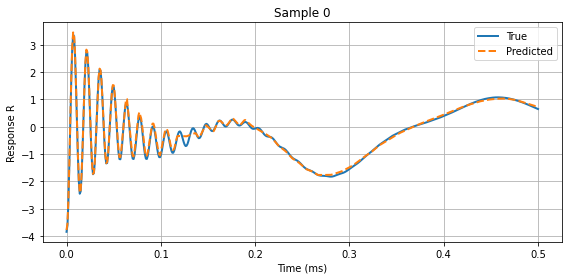

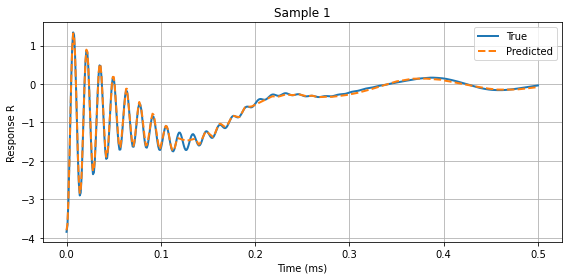

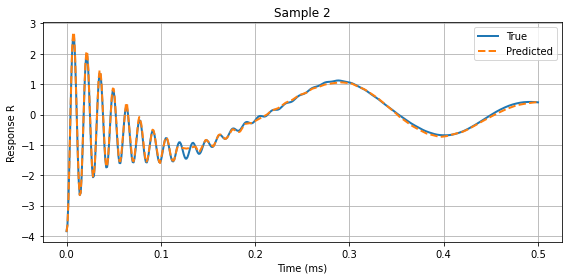

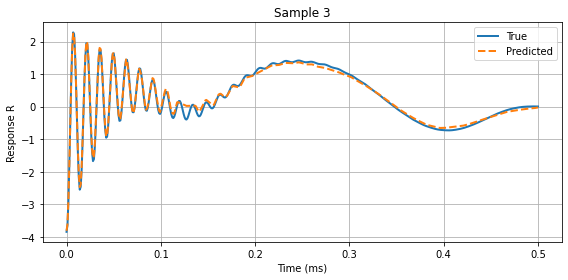

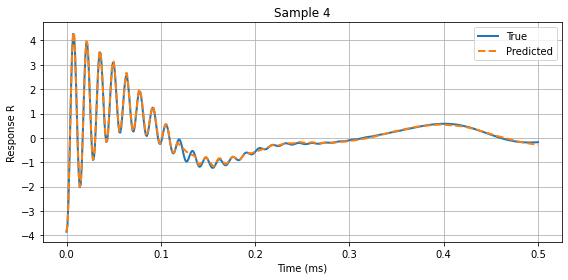

Plots saved.


In [7]:
# Inference

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Reshape, Conv2D, PReLU, Flatten, Dense, Activation
from tensorflow.keras.losses import MeanSquaredError
import matplotlib
import matplotlib.pyplot as plt
import time
import os
from scipy.interpolate import interp1d
def normalize(X_func, X_loc, y, Par):
    X_func = (X_func - Par['p_mean'])/Par['p_std'] 
    X_loc  = (X_loc - np.min(X_loc))/(np.max(X_loc) - np.min(X_loc))
    y = (y - Par['r_mean'])/Par['r_std'] 

    return X_func.astype(np.float32), X_loc.astype(np.float32), y.astype(np.float32)


def preprocess(dataset, m, npoints_output, is_test=False):
    p = dataset['del_p']
    t = dataset['t']
    r = dataset['R']

    P = interp1d(t, p, kind='cubic')
    R = interp1d(t, r, kind='cubic')

    t_min = 0
    t_max = 5 * 10**-4

    X_func = P(np.linspace(t_min, t_max, m)) #[1500, m]
    X_loc  = np.linspace(t_min, t_max, npoints_output)[:, None] #[npoints_output,1]
    y      = R(np.ravel(X_loc)) #[1500, npoints_output]

    if is_test:
        X_func = X_func[:50]
        y = y[:50]

    return X_func, X_loc, y

# Load model & weights and plots
Par = {}

def denormalize(y, Par):
    return y * Par['r_std'] + Par['r_mean']

train_dataset = np.load('res_1000_1.npz')
test_dataset = np.load('res_1000_08.npz')

m = 200
npoints_output = 500

Par['address'] = 'don_'+str(m)

print(Par['address'])
print('------\n')

X_func_train, X_loc_train, y_train = preprocess(train_dataset, m, npoints_output)
X_func_test, X_loc_test, y_test = preprocess(test_dataset, m, npoints_output, is_test=True)

Par['p_mean'] = np.mean(X_func_train)
Par['p_std']  = np.std(X_func_train)

Par['r_mean'] = np.mean(y_train)
Par['r_std']  = np.std(y_train)

X_func_train, X_loc_train, y_train = normalize(X_func_train, X_loc_train, y_train, Par)
X_func_test, X_loc_test, y_test    = normalize(X_func_test, X_loc_test, y_test, Par)

print('X_func_train: ', X_func_train.shape, '\nX_loc_train: ', X_loc_train.shape, '\ny_train: ', y_train.shape)
print('X_func_test: ', X_func_test.shape, '\nX_loc_test: ', X_loc_test.shape, '\ny_test: ', y_test.shape)


model = DeepONet_Model(Par)
_ = model(X_func_test[:1], X_loc_test)  # Build model
ep = 9900
model.load_weights("model_"+str(ep)+".weights.h5")

# Predict
y_pred_norm = model(X_func_test, X_loc_test).numpy()

# Plot
num_plots = min(5, X_func_test.shape[0])
t = np.linspace(0, 5e-4, npoints_output)

for i in range(num_plots):
    plt.figure(figsize=(8, 4))
    plt.plot(t * 1e3, y_test[i], label="True", linewidth=2)
    plt.plot(t * 1e3, y_pred_norm[i], '--', label="Predicted", linewidth=2)
    plt.xlabel("Time (ms)")
    plt.ylabel("Response R")
    plt.title(f"Sample {i}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"prediction_sample_{i}.png")
    plt.close()

print("Plots saved.")

In [8]:
import matplotlib.pyplot as plt
plt.plot(t * 1e3, y_test[i], label="True", linewidth=2)
plt.plot(t * 1e3, y_pred_norm[i], '--', label="Predicted", linewidth=2)
plt.xlabel("Time (ms)")
plt.ylabel("Response R")
#plt.title(f"Sample {i}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-8-82b8cace1dfc>:10: UserWarning: Matplotlib is currently using nbAgg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<IPython.core.display.Javascript object>


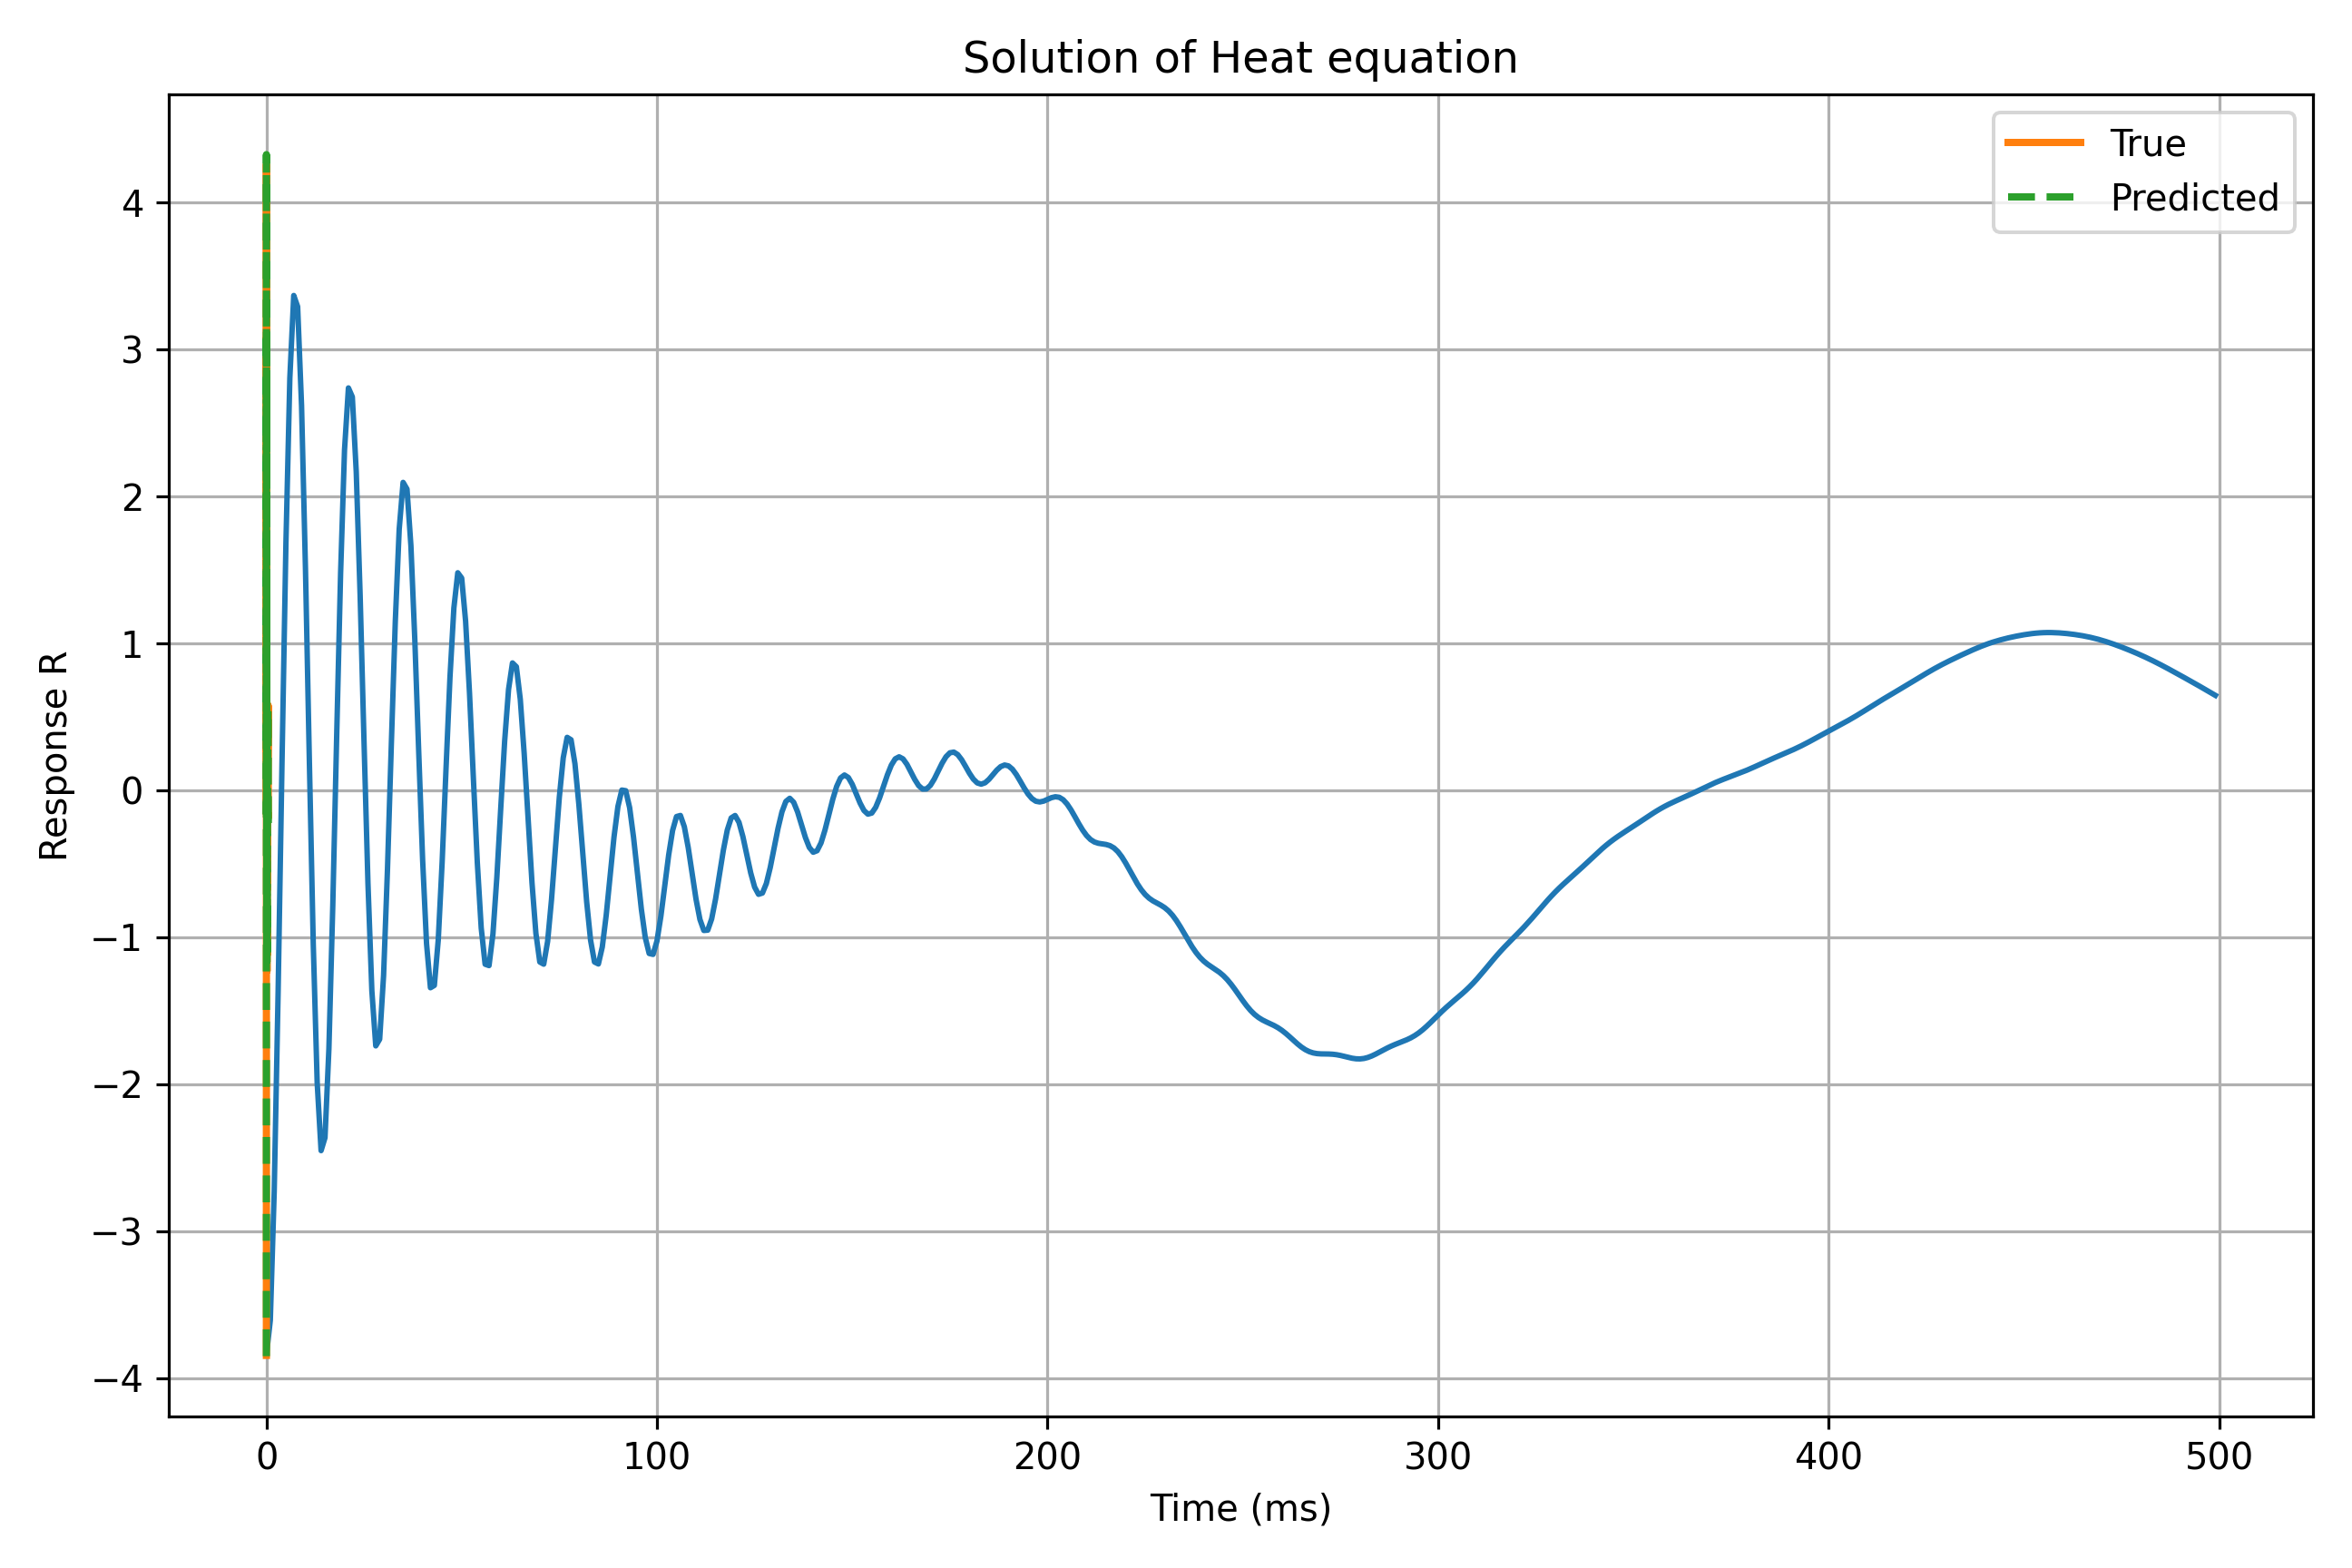

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(y_test[0]);
#ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Bubble equation');